In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [2]:
from torchvision import datasets #to load datasets
from torchvision.transforms import ToTensor #to make useful for torch

In [3]:
import torch #for various utility functions

import torch.nn as nn #for model library
import torch.nn.functional as F #for additional optimised routines

from torch.utils.data import DataLoader #for an easy dataloader


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [5]:
train_dataset = datasets.MNIST(root = 'datasets', 
                               train = True, 
                               transform = ToTensor(),
                               download = True) 

test_dataset = datasets.MNIST(root = 'datasets', 
                              train = False, 
                              transform = ToTensor(),
                              download = True) 


In [6]:
batch_size = 128
loaders = {
    'train' : torch.utils.data.DataLoader(train_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=2),
    
    'test'  : torch.utils.data.DataLoader(test_dataset,                                         
                                          shuffle=True, 
                                          num_workers=2),
}


In [7]:
x = iter(loaders['train']).next()

In [8]:
x[1].shape

torch.Size([128])

In [9]:
class Encoder(nn.Module):
    def __init__(self, input_size, layers, latent_dims):
        super().__init__()
        self.layer0 = nn.Linear(input_size, layers[0])
        self.layer1 = nn.Linear(layers[0], layers[1])
        self.layer2 = nn.Linear(layers[1], latent_dims)
        
    def forward(self, X): 
        X = torch.flatten(X, start_dim=1)
        X = F.relu(self.layer0(X))
        X = F.relu(self.layer1(X))
        return self.layer2(X)
        

In [10]:
class Decoder(nn.Module):
    def __init__(self, latent_dims, layers, output_size):
        super().__init__()
        self.layer0 = nn.Linear(latent_dims, layers[1])
        self.layer1 = nn.Linear(layers[1], layers[0])
        self.layer2 = nn.Linear(layers[0], output_size)
        
    def forward(self, z): 
        z = F.relu(self.layer0(z))
        z = F.relu(self.layer1(z))
        z = torch.sigmoid(self.layer2(z)) #E
        return  z

In [11]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, layers, latent_dims):
        super().__init__()
        self.encoder = Encoder(input_size, layers, latent_dims)
        self.decoder = Decoder(latent_dims, layers, input_size)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [12]:
input_size, latent_dims = 28*28, 2
layers = [512, 256]

model = Autoencoder(input_size, layers, latent_dims)

criterion = nn.MSELoss()#nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)

In [13]:
print(model)

Autoencoder(
  (encoder): Encoder(
    (layer0): Linear(in_features=784, out_features=512, bias=True)
    (layer1): Linear(in_features=512, out_features=256, bias=True)
    (layer2): Linear(in_features=256, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (layer0): Linear(in_features=2, out_features=256, bias=True)
    (layer1): Linear(in_features=256, out_features=512, bias=True)
    (layer2): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [14]:
def train(model, iterator, criterion, optimizer):
    #initial train step <- on what? possibly random weights
    model.train()
    
    #zero the loss and accuracy
    epoch_loss = 0
    
    for x,_ in tqdm.tqdm(iterator, desc="Evaluating", leave=False):
        #reset weights in optimizer
        optimizer.zero_grad()

        #predict using the model
        xbar = model(x)
        
        #reshape to images
        xbar = xbar.reshape((-1, 1, 28, 28))
        
        #calculate the loss
        loss = criterion(xbar, x)

        #propagate the loss backwards
        loss.backward()
        
        #update the weights
        optimizer.step()
        
        #update the loss
        epoch_loss += loss.item()

    print(f"training loss: {epoch_loss /len(iterator):3.7}")        
        
        

In [15]:
epochs = 10

for e in range(1,epochs):
    print(f"Epoch: {e}")
    train(model, loaders['train'], criterion, optimizer)
    

Epoch: 1


training loss: 0.05453965
Epoch: 2


training loss: 0.0438982
Epoch: 3


training loss: 0.04166084
Epoch: 4


training loss: 0.04037794
Epoch: 5


training loss: 0.03947362
Epoch: 6


training loss: 0.03879309
Epoch: 7


training loss: 0.03825293
Epoch: 8


training loss: 0.03779675
Epoch: 9


training loss: 0.03739443


In [16]:
@torch.no_grad()
def evaluate(model, iterator, criterion, optimizer):
    #initial train step <- on what? possibly random weights
    model.eval()
    
    #zero the loss
    epoch_loss = 0
    
    for x,label in tqdm.tqdm(iterator, desc="Evaluating", leave=False):
        #predict using the model
        xbar = model(x)
        
        #reshape to images
        xbar = xbar.reshape((-1, 1, 28, 28))
 
        #calculate the loss
        loss = criterion(xbar, x)
        
        #update the loss
        epoch_loss += loss.item()
    
    print(f"test loss: {epoch_loss /len(iterator):3.7}")        
        
        

In [17]:
evaluate(model, loaders['test'], criterion, optimizer)
    

test loss: 0.03754342


In [18]:
# creating a file
with open('AE_MNIST.p', 'wb') as f:
    torch.save(model, f)

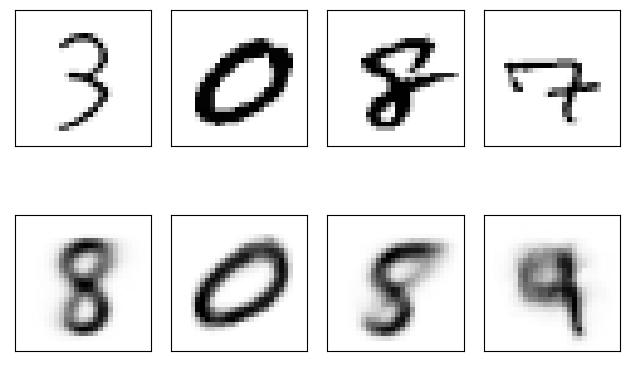

In [19]:
xbar = model(x[0]).detach().numpy()
xbar = xbar.reshape((-1, 1, 28, 28))
fig, ax = plt.subplots(2,4)
random_place = 10
for n in range(4):
    ax[0][n].imshow(x[0][n + random_place][0],cmap='Greys')
    ax[0][n].xaxis.set_visible(False) # same for y axis.
    ax[0][n].yaxis.set_visible(False) # same for y axis.
    ax[1][n].imshow(xbar[n + random_place][0],cmap='Greys')
    ax[1][n].xaxis.set_visible(False) # same for y axis.
    ax[1][n].yaxis.set_visible(False) # same for y axis.
plt.tight_layout()
plt.show()

In [20]:
latent_space = model.encoder(train_dataset.data.reshape(-1,28*28).float())

In [21]:
labels = train_dataset.targets.numpy()
latent_space = latent_space.detach().numpy()

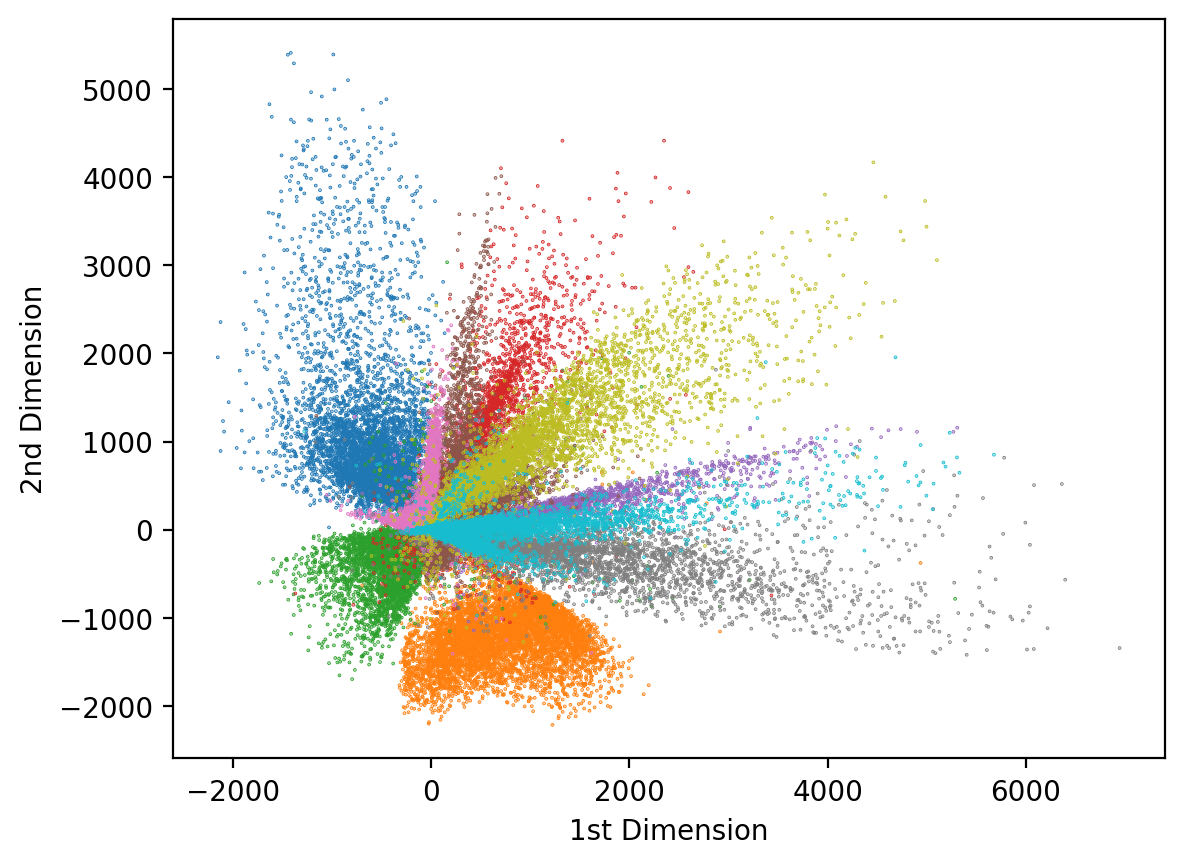

In [32]:
from matplotlib import cm

colors = plt.get_cmap('tab10')

plt.figure(dpi=200)
for i in range(10):
    index = labels == i
    plt.scatter(latent_space[index,0], latent_space[index,1], s=0.1, c=colors(labels[index]), label=i)
# plt.legend(markerscale=10)

plt.xlabel('1st Dimension')
plt.ylabel('2nd Dimension')
plt.show()

In [23]:
X_train = model.encoder(train_dataset.data.reshape(-1,28*28).float()).detach().numpy()
y_train = train_dataset.targets.numpy()

X_test = model.encoder(test_dataset.data.reshape(-1,28*28).float()).detach().numpy()
y_test = test_dataset.targets.numpy()

clf = RandomForestClassifier(max_depth=4, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.6376
